# Figure experimental / scratch space

In [1]:
import sys
sys.path.append('/g/data/mn51/users/jb6465/drought-github/submodules/gwls')
from gwl import get_GWL_timeslice, get_GWL_syear_eyear
sys.path.append('/g/data/mn51/users/jb6465/drought-github')
import utils
sys.path.append('/g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps')
from acs_area_statistics import acs_regional_stats, get_regions
from acs_plotting_maps import *
import glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rio
import geopandas
from shapely.geometry import mapping
from datetime import datetime
import seaborn as sns

In [2]:
GWL=3.0
AGCD_MASK_SWITCH = True

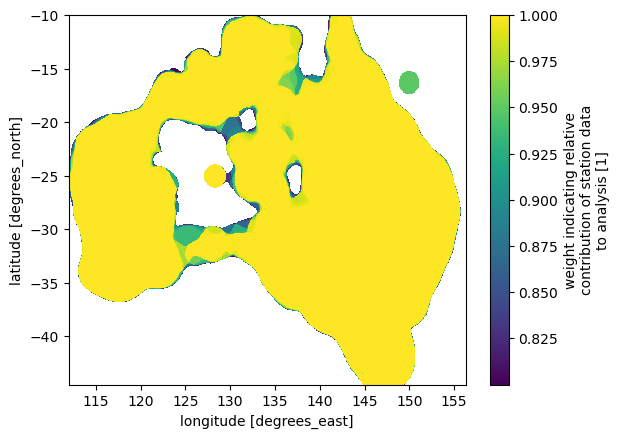

In [3]:
q_mask = np.ma.masked_greater(xr.open_dataset("/g/data/mn51/users/dh4185/agcd_v1-0-2_precip_weight_r005_daily_1960_2022fraction_ge1.nc").fraction,0.8) if AGCD_MASK_SWITCH else None
xr.open_dataset("/g/data/mn51/users/dh4185/agcd_v1-0-2_precip_weight_r005_daily_1960_2022fraction_ge1.nc").fraction.where(q_mask.mask).plot()

In [10]:
files = []

files.extend(sorted(glob.glob("/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/QME-AGCD/full_period/*.nc")))
files.extend(sorted(glob.glob("/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/MRNBC-AGCD/full_period/*.nc")))


ACS_BOM_CCAM_files = [file for file in files if 'BOM' in file or 'CSIRO' in file]

In [11]:
%%time
AGCD_xr = xr.open_dataset('/g/data/ia39/ncra/drought_aridity/spi/SPI3_AGCD_baseperiod19652014.nc').where(q_mask.mask)
AGCD_xr = AGCD_xr.sel(time=AGCD_xr['time'].dt.year.isin(range(1961, 2023)))

correlation_list = []
ens_timeseries_list = []
for file in ACS_BOM_CCAM_files:
    ens_xr = xr.open_dataset(file).where(q_mask.mask)
    ens_xr = ens_xr.sel(time=ens_xr['time'].dt.year.isin(range(1901, 2023)))
    ens_xr['time'] = AGCD_xr['time']
    ens_xr.SPI3.values = np.ma.masked_invalid(ens_xr.SPI3.values)
    correlation_list.append(xr.corr(AGCD_xr.SPI3, ens_xr.SPI3, dim="time"))
    ens_timeseries_list.append(ens_xr.SPI3.mean(dim=['lat', 'lon']))
    del ens_xr
ens_timeseries_list.append(AGCD_xr.SPI3.mean(dim=['lat', 'lon']))

CPU times: user 9min 54s, sys: 6min 7s, total: 16min 1s
Wall time: 17min 1s


In [12]:
ens = [file.split('_')[6]+'_'+file.split('_')[-4]+'_'+file.split('_')[3].split('/')[1].split('-')[0] for file in ACS_BOM_CCAM_files]

In [13]:
len(ens[14:])

14

In [14]:
MME_xr = xr.concat([corr_xr.assign_coords(MME=ens_idx) for ens_idx, corr_xr in enumerate(correlation_list)], dim='MME')
MME_timeseries_xr = xr.concat([corr_xr.assign_coords(MME=ens_idx) for ens_idx, corr_xr in enumerate(ens_timeseries_list)], dim='MME')

In [15]:
QME_timeseries = MME_timeseries_xr.sel(MME=slice(0,13))
MRNBC_timeseries = MME_timeseries_xr.sel(MME=slice(14,27))
AGCD_timeseries = MME_timeseries_xr.sel(MME=28)

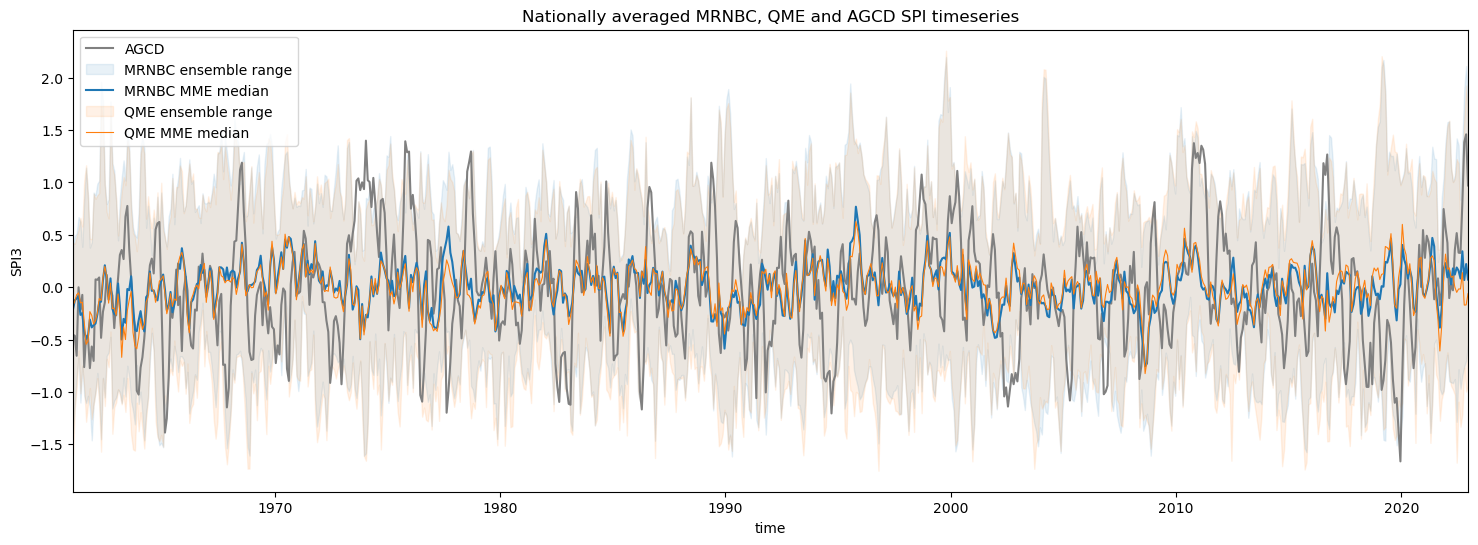

In [16]:
QME_min = QME_timeseries.min(dim='MME')
QME_max = QME_timeseries.max(dim='MME')
QME_median = QME_timeseries.median(dim='MME')

MRNBC_min = MRNBC_timeseries.min(dim='MME')
MRNBC_max = MRNBC_timeseries.max(dim='MME')
MRNBC_median = MRNBC_timeseries.median(dim='MME')

plt.figure(figsize=(18, 6))

AGCD_timeseries.plot(color='grey', label='AGCD')
plt.fill_between(MRNBC_timeseries.coords['time'], MRNBC_min, MRNBC_max, color='tab:blue', alpha=0.1, label='MRNBC ensemble range')
# AGCD_timeseries.plot(color='black', label='AGCD', linewidth=0.5)

MRNBC_median.plot(color='tab:blue', label='MRNBC MME median')
# MRNBC_max.plot(color='tab:blue', alpha=0.3, linewidth=0.5)
# MRNBC_min.plot(color='tab:blue', alpha=0.3, linewidth=0.5)

plt.fill_between(MRNBC_timeseries.coords['time'], QME_min, QME_max, color='tab:orange', alpha=0.1, label='QME ensemble range')
QME_median.plot(color='tab:orange', label='QME MME median', linewidth=0.8)
# QME_max.plot(color='black', alpha=0.3, linewidth=0.5)
# QME_min.plot(color='black', alpha=0.3, linewidth=0.5)

# Highlight areas where SPI3 < -1 (e.g., below the median curve)ighlight =   # Mask values where SPI3 < -1

# plt.fill_between(AGCD_timeseries.coords['time'], -4, 5, where=(AGCD_timeseries < -1 and ), color='red', alpha=0.3, label='SPI3 < -1')

plt.title('Nationally averaged MRNBC, QME and AGCD SPI timeseries')
plt.xlim(AGCD_timeseries.coords['time'].min().values, AGCD_timeseries.coords['time'].max().values)
# plt.ylim(-2,2)
plt.legend()
plt.show()

In [17]:
QME_xr = MME_xr.sel(MME=slice(0,13))
MRNBC_xr = MME_xr.sel(MME=slice(14,27))

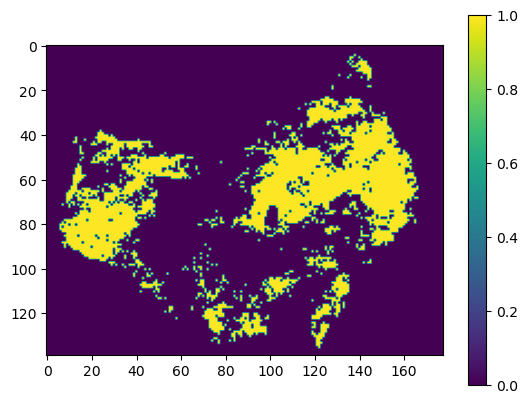

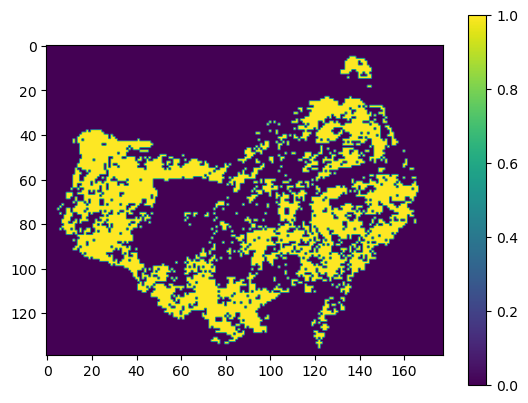

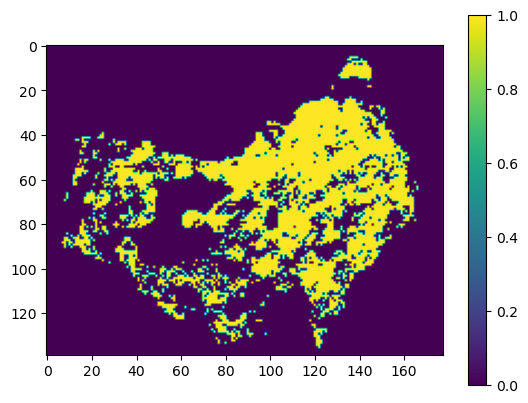

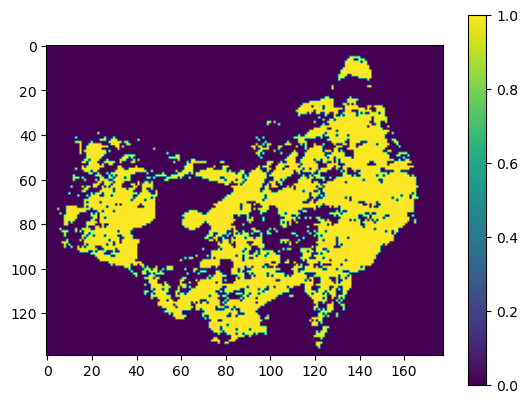

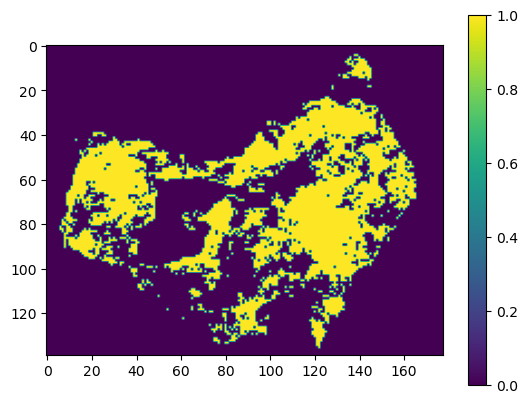

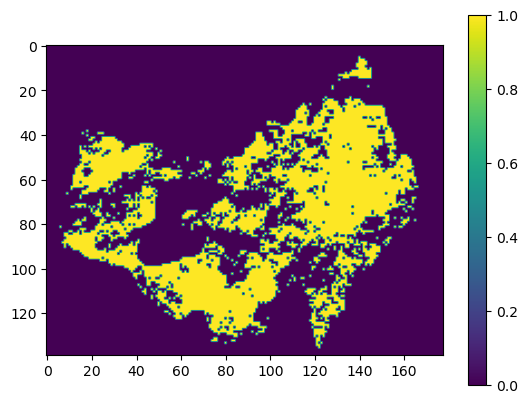

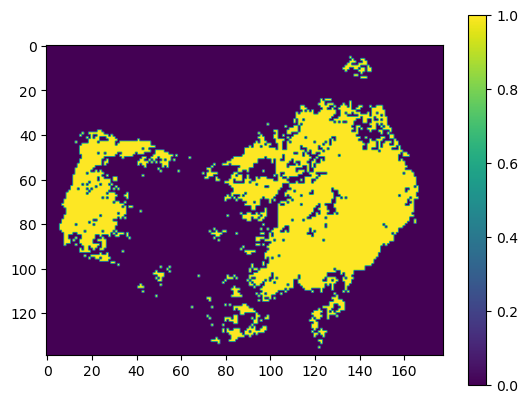

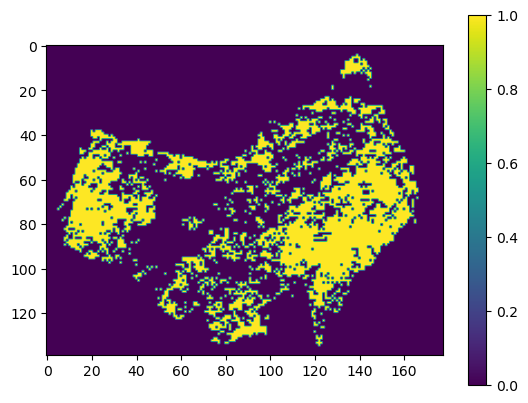

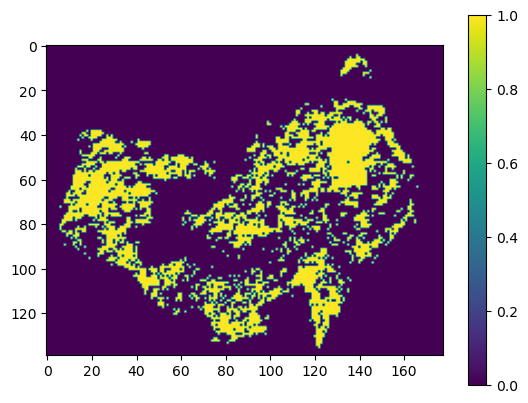

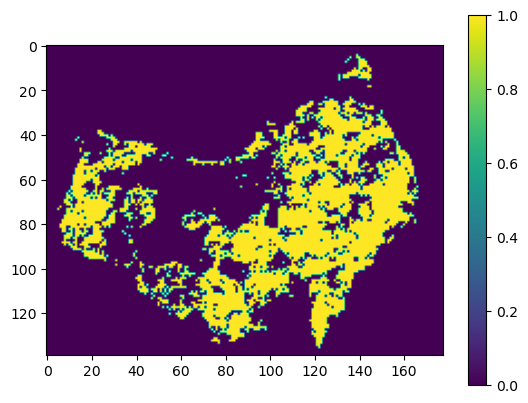

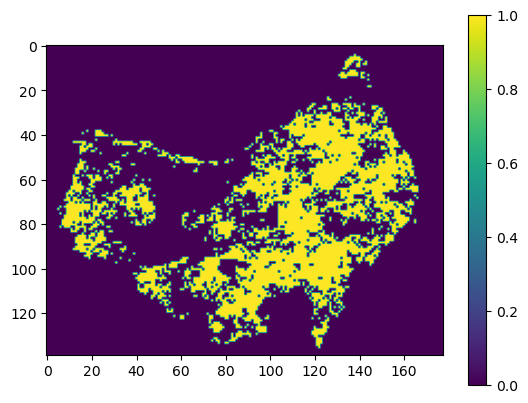

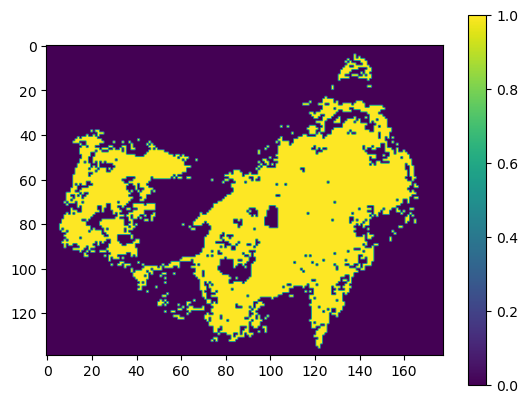

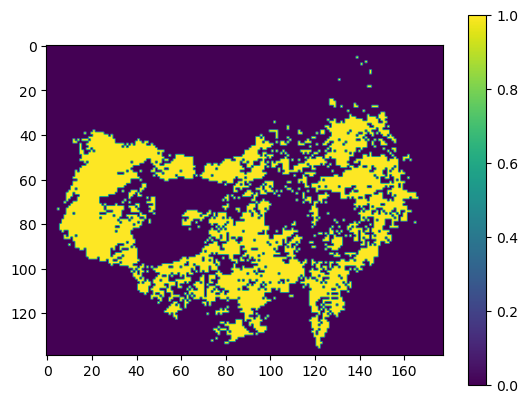

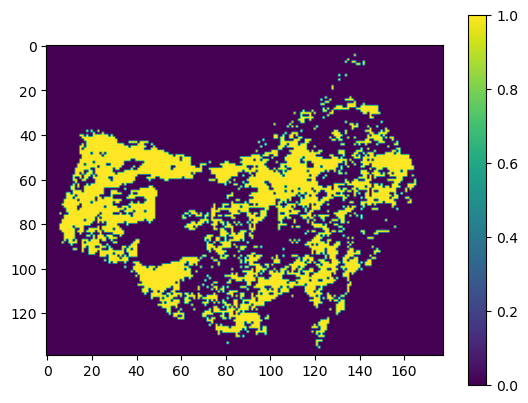

<Figure size 640x480 with 0 Axes>

In [18]:
for ens_idx in range(0,14):
    plt.imshow((MRNBC_xr.values>QME_xr.values)[ens_idx])
    plt.colorbar()
    plt.show()
    plt.clf()

In [19]:
best_corr = xr.zeros_like(MME_xr[0])
best_corr.values = np.argmax(MME_xr.values, axis=0)

In [20]:
cd /g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps

/g/data/mn51/users/jb6465/drought-github/submodules/plotting_maps


In [21]:
from acs_plotting_maps import *

In [22]:
ens[14:]

['ACCESS-CM2_BOM_MRNBC',
 'ACCESS-CM2_CSIRO_MRNBC',
 'ACCESS-ESM1-5_BOM_MRNBC',
 'ACCESS-ESM1-5_CSIRO_MRNBC',
 'CESM2_BOM_MRNBC',
 'CESM2_CSIRO_MRNBC',
 'CMCC-ESM2_BOM_MRNBC',
 'CMCC-ESM2_CSIRO_MRNBC',
 'CNRM-ESM2-1_CSIRO_MRNBC',
 'EC-Earth3_BOM_MRNBC',
 'EC-Earth3_CSIRO_MRNBC',
 'MPI-ESM1-2-HR_BOM_MRNBC',
 'NorESM2-MM_BOM_MRNBC',
 'NorESM2-MM_CSIRO_MRNBC']

CPU times: user 1min 51s, sys: 343 ms, total: 1min 52s
Wall time: 1min 52s


(<Figure size 670x400 with 2 Axes>, <GeoAxes: >)

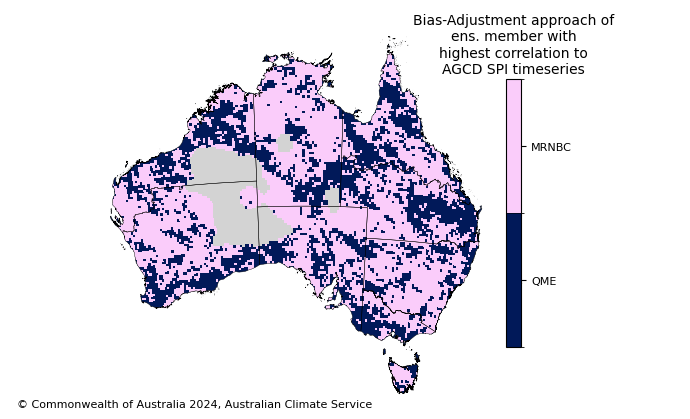

In [248]:
%%time
plot_acs_hazard(data = ((best_corr>13)),
                        regions = regions_dict['ncra_regions'],
                        cbar_label = "Bias-Adjustment approach of\nens. member with\nhighest correlation to\nAGCD SPI timeseries",
                        cmap = cmap_dict['ipcc_misc_seq_3'],
                        cbar_extend = "max",
                        ticks=np.arange(0, 1.1, 1),
                        tick_labels=['QME', 'MRNBC'],
                        title = " ",
                        # dataset_name = "BARPA-R/CCAM downscaled \nNon bias-corrected \n(/g/data/ia39)." if BC_SWITCH == False else f"BARPA-R/CCAM downscaled \nAGCD-{BC_TYPE} bias-corrected \n(/g/data/ia39).",
                        # date_range = f"MME {str(int(percentile*100))}th percentile, GWL{str(GWL)}",
                        contourf = False,
                        agcd_mask=AGCD_MASK_SWITCH,
                        contour = False,
                        watermark= None,
                        issued_date="",
                        # outfile = f"/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/figures/SPI3_pct_time_below_-1_GWL{str(GWL)}_percentile_{str(int(percentile*100))}.png" if BC_SWITCH == False else f"/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/{BC_TYPE}/figures/SPI3_pct_time_below_-1_GWL{str(GWL)}_ACS-QME-AGCD-1960-2022_percentile_{str(int(percentile*100))}_{'masked' if AGCD_MASK_SWITCH == True else ''}.png"
                    )

CPU times: user 1min 52s, sys: 438 ms, total: 1min 52s
Wall time: 1min 52s


(<Figure size 670x400 with 2 Axes>, <GeoAxes: >)

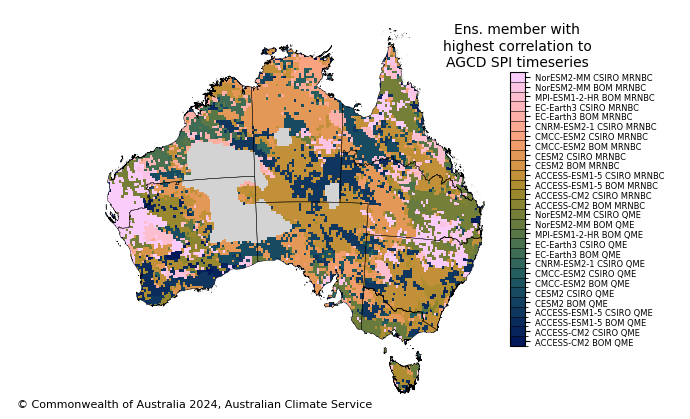

In [24]:
%%time
plot_acs_hazard(data = (best_corr),
                        regions = regions_dict['ncra_regions'],
                        cbar_label = "Ens. member with\nhighest correlation to\nAGCD SPI timeseries",
                        cmap = cmap_dict['ipcc_misc_seq_3'],
                        cbar_extend = "max",
                        ticks=np.arange(0, 27.1, 1),
                        tick_labels=[string.replace('_', ' ') for string in ens],
                        title = " ",
                        # dataset_name = "BARPA-R/CCAM downscaled \nNon bias-corrected \n(/g/data/ia39)." if BC_SWITCH == False else f"BARPA-R/CCAM downscaled \nAGCD-{BC_TYPE} bias-corrected \n(/g/data/ia39).",
                        # date_range = f"MME {str(int(percentile*100))}th percentile, GWL{str(GWL)}",
                        contourf = False,
                        agcd_mask=AGCD_MASK_SWITCH,
                        contour = False,
                        watermark= None,
                        issued_date="",
                        # outfile = f"/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/figures/SPI3_pct_time_below_-1_GWL{str(GWL)}_percentile_{str(int(percentile*100))}.png" if BC_SWITCH == False else f"/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/{BC_TYPE}/figures/SPI3_pct_time_below_-1_GWL{str(GWL)}_ACS-QME-AGCD-1960-2022_percentile_{str(int(percentile*100))}_{'masked' if AGCD_MASK_SWITCH == True else ''}.png"
                    )

In [5]:
%%time
plot_dict={}
for file in files:
    GCM = file.split('_')[6]
    RCM = 'BARPA-R' if file.split('_')[-4] == 'BOM' else 'CCAM-v2203-SN' if file.split('_')[-4] == 'CSIRO' else file.split('_')[-4]
    BC = file.split('_')[-1].split('-')[1]
    variant_id = file.split('_')[8]
    print(f'{GCM}_{variant_id}_{RCM}_{BC}')
    
    target_xr = xr.open_dataset(file)['SPI3']
    syear, eyear = get_GWL_syear_eyear('CMIP6',GCM,variant_id,'ssp370',GWL=GWL) 
    GWLx_xr = target_xr.sel(time=target_xr['time'].dt.year.isin(range(syear, eyear+1))) #have to do it this way as get_GWL_timeslice throws errors with 360 day calendars
    syear, eyear = get_GWL_syear_eyear('CMIP6',GCM,variant_id,'ssp370',GWL='1.2')
    GWL12_xr = target_xr.sel(time=target_xr['time'].dt.year.isin(range(syear, eyear+1)))
    
    GWLx_pct_time_below = 100*((GWLx_xr)<=-1).sum(dim='time')/len(GWLx_xr.time)
    GWL12_pct_time_below = 100*((GWL12_xr)<=-1).sum(dim='time')/len(GWL12_xr.time)
    
    plot_dict[f'{GCM}_{variant_id}_{RCM}_{BC}']=100*((GWLx_pct_time_below-GWL12_pct_time_below)/GWL12_pct_time_below).where(q_mask.mask) if AGCD_MASK_SWITCH==True else 100*((GWLx_pct_time_below-GWL12_pct_time_below)/GWL12_pct_time_below)

ACCESS-CM2_r4i1p1f1_BARPA-R_QME
ACCESS-CM2_r4i1p1f1_CCAM-v2203-SN_QME
ACCESS-CM2_r4i1p1f1_UQ-DES_QME
ACCESS-ESM1-5_r6i1p1f1_BARPA-R_QME
ACCESS-ESM1-5_r6i1p1f1_CCAM-v2203-SN_QME
ACCESS-ESM1-5_r6i1p1f1_NARCliM2-0-WRF412R3_QME
ACCESS-ESM1-5_r6i1p1f1_NARCliM2-0-WRF412R5_QME
ACCESS-ESM1-5_r6i1p1f1_UQ-DES_QME
CESM2_r11i1p1f1_BARPA-R_QME
CESM2_r11i1p1f1_CCAM-v2203-SN_QME
CMCC-ESM2_r1i1p1f1_BARPA-R_QME
CMCC-ESM2_r1i1p1f1_CCAM-v2203-SN_QME
CMCC-ESM2_r1i1p1f1_UQ-DES_QME
CNRM-CM6-1-HR_r1i1p1f2_UQ-DES_QME
CNRM-ESM2-1_r1i1p1f2_CCAM-v2203-SN_QME
EC-Earth3-Veg_r1i1p1f1_NARCliM2-0-WRF412R3_QME
EC-Earth3-Veg_r1i1p1f1_NARCliM2-0-WRF412R5_QME
EC-Earth3_r1i1p1f1_BARPA-R_QME
EC-Earth3_r1i1p1f1_CCAM-v2203-SN_QME
EC-Earth3_r1i1p1f1_UQ-DES_QME
FGOALS-g3_r4i1p1f1_UQ-DES_QME
GFDL-ESM4_r1i1p1f1_UQ-DES_QME
GISS-E2-1-G_r2i1p1f2_UQ-DES_QME
MPI-ESM1-2-HR_r1i1p1f1_BARPA-R_QME
MPI-ESM1-2-HR_r1i1p1f1_NARCliM2-0-WRF412R3_QME
MPI-ESM1-2-HR_r1i1p1f1_NARCliM2-0-WRF412R5_QME
MRI-ESM2-0_r1i1p1f1_UQ-DES_QME
NorESM2-MM_r1i1p1f

In [6]:
df = pd.DataFrame({key: [value.mean().values] for key, value in plot_dict.items()})


In [7]:
df

,ACCESS-CM2_r4i1p1f1_BARPA-R_QME,ACCESS-CM2_r4i1p1f1_CCAM-v2203-SN_QME,ACCESS-CM2_r4i1p1f1_UQ-DES_QME,ACCESS-ESM1-5_r6i1p1f1_BARPA-R_QME,ACCESS-ESM1-5_r6i1p1f1_CCAM-v2203-SN_QME,ACCESS-ESM1-5_r6i1p1f1_NARCliM2-0-WRF412R3_QME,ACCESS-ESM1-5_r6i1p1f1_NARCliM2-0-WRF412R5_QME,ACCESS-ESM1-5_r6i1p1f1_UQ-DES_QME,CESM2_r11i1p1f1_BARPA-R_QME,CESM2_r11i1p1f1_CCAM-v2203-SN_QME,...,MPI-ESM1-2-HR_r1i1p1f1_NARCliM2-0-WRF412R3_MRNBC,MPI-ESM1-2-HR_r1i1p1f1_NARCliM2-0-WRF412R5_MRNBC,MRI-ESM2-0_r1i1p1f1_UQ-DES_MRNBC,NorESM2-MM_r1i1p1f1_BARPA-R_MRNBC,NorESM2-MM_r1i1p1f1_CCAM-v2203-SN_MRNBC,NorESM2-MM_r1i1p1f1_NARCliM2-0-WRF412R3_MRNBC,NorESM2-MM_r1i1p1f1_NARCliM2-0-WRF412R5_MRNBC,NorESM2-MM_r1i1p1f1_UQ-DES_MRNBC,UKESM1-0-LL_r1i1p1f2_NARCliM2-0-WRF412R3_MRNBC,UKESM1-0-LL_r1i1p1f2_NARCliM2-0-WRF412R5_MRNBC
0,5.364859131060931,-9.347145789890794,-26.253815782828003,89.81937129433275,96.59205303724193,80.84346300794856,77.22369156453226,37.03284198987791,-7.5440216362546035,10.749231579464379,...,33.54593016183181,36.91049962565435,20.117213435325542,45.59851324141487,17.582231133007255,38.72365310089583,40.851685673109706,0.9052075012209289,34.57085594712393,39.660012456113776


In [8]:
plot_data = pd.DataFrame([
    {"GCM": col.split('_')[0]+', '+col.split('_')[1], "RCM_BC": col.split('_')[2]+'-'+col.split('_')[3], "GWLx_change": val} 
    for col in df.columns  # Iterate over each column in df
    for val in df[col].values.astype('float32')  # Iterate over the values in the column
])


In [10]:
NCRA_df = plot_data[plot_data['RCM_BC'].isin(['BARPA-R-QME', 'CCAM-v2203-SN-QME'])].copy()
NCRA_df['RCM_BC'] = 'NCRA'
plot_data = pd.concat([plot_data, NCRA_df], ignore_index=True)


In [11]:
plot_data

,GCM,RCM_BC,GWLx_change
0,"ACCESS-CM2, r4i1p1f1",BARPA-R-QME,5.364859
1,"ACCESS-CM2, r4i1p1f1",CCAM-v2203-SN-QME,-9.347146
2,"ACCESS-CM2, r4i1p1f1",UQ-DES-QME,-26.253817
3,"ACCESS-ESM1-5, r6i1p1f1",BARPA-R-QME,89.819374
4,"ACCESS-ESM1-5, r6i1p1f1",CCAM-v2203-SN-QME,96.592056
...,...,...,...
77,"EC-Earth3, r1i1p1f1",NCRA,-14.391247
78,"EC-Earth3, r1i1p1f1",NCRA,-14.525576
79,"MPI-ESM1-2-HR, r1i1p1f1",NCRA,21.509310
80,"NorESM2-MM, r1i1p1f1",NCRA,44.601524


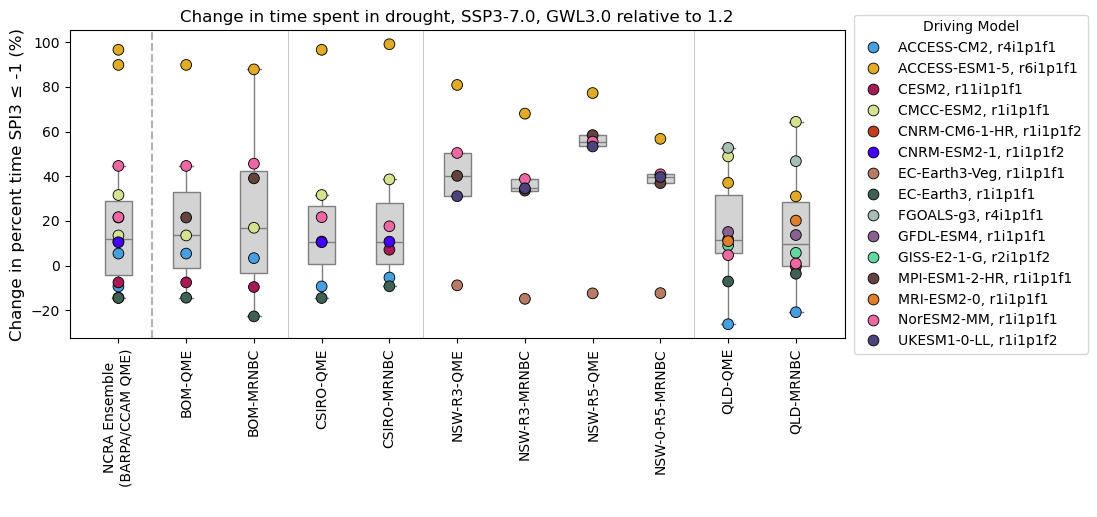

In [18]:

plt.figure(figsize=(10, 4))
rcm_order = ['NCRA', 'BARPA-R-QME', 'BARPA-R-MRNBC', 'CCAM-v2203-SN-QME', 'CCAM-v2203-SN-MRNBC', 'NARCliM2-0-WRF412R3-QME', 'NARCliM2-0-WRF412R3-MRNBC', 'NARCliM2-0-WRF412R5-QME', 'NARCliM2-0-WRF412R5-MRNBC','UQ-DES-QME', 'UQ-DES-MRNBC']

sns.boxplot(data=plot_data, x='RCM_BC', y='GWLx_change', color='lightgrey', order=rcm_order, width=0.4)
gcm_palette = ['#469FE1', '#E1AB27', '#A81A55', '#D7E291', '#C23E21', '#4200FF', '#B77B66', '#3E6153', '#A8BDB4', '#88618F', '#61D99E', '#61443E', '#DF7F2D', '#ED67A3', '#4E427A']
sns.scatterplot(data=plot_data, x='RCM_BC', y='GWLx_change', hue='GCM', palette=gcm_palette, s=60, edgecolor='black', legend=True, zorder=10)
plt.xticks(rotation=90)
plt.legend(title="Driving Model", bbox_to_anchor=(1.012, 0.5), loc='center left', borderaxespad=0.)
plt.title(f"Change in time spent in drought, SSP3-7.0, GWL{GWL} relative to 1.2")
new_labels = ['NCRA Ensemble\n(BARPA/CCAM QME)', 'BOM-QME', 'BOM-MRNBC', 'CSIRO-QME', 'CSIRO-MRNBC', 'NSW-R3-QME', 'NSW-R3-MRNBC', 'NSW-R5-QME', 'NSW-0-R5-MRNBC','QLD-QME', 'QLD-MRNBC'] 
plt.xticks(ticks=range(len(plot_data['RCM_BC'].unique())), labels=new_labels)
plt.xlabel(" ", fontsize=12)  # Custom x-axis label
plt.ylabel("Change in percent time SPI3 ≤ -1 (%)", fontsize=12)

plt.axvline(0.5, color='black', linestyle='--', alpha=0.3)  
plt.axvline(2.5, color='black', linestyle='-', alpha=0.3, linewidth='0.5') 
plt.axvline(4.5, color='black', linestyle='-', alpha=0.3, linewidth='0.5') 
plt.axvline(8.5, color='black', linestyle='-', alpha=0.3, linewidth='0.5') 
plt.show()


[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),
 (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353)]

In [245]:
range(len(plot_data['RCM_BC'].unique()))

range(0, 11)